<a href="https://colab.research.google.com/github/tenvol/tsf00/blob/master/intro_to_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Neural Networks

**Learning Objectives:**
  * Define a neural network (NN) and its hidden layers using the TensorFlow `DNNRegressor` class
  * Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model

In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting `median_house_value` directly.

## Setup

First, let's load and prepare the data.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [3]:
california_housing_dataframe.shape

(17000, 9)

In [4]:
california_housing_dataframe.columns

Index([u'longitude', u'latitude', u'housing_median_age', u'total_rooms',
       u'total_bedrooms', u'population', u'households', u'median_income',
       u'median_house_value'],
      dtype='object')

In [5]:
california_housing_dataframe.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2976,-117.8,33.9,16.0,3781.0,504.0,1665.0,499.0,7.3,335600.0
6147,-118.2,33.9,34.0,1060.0,276.0,1215.0,250.0,2.1,84700.0
4532,-118.0,34.1,23.0,602.0,135.0,409.0,123.0,3.5,146400.0
1533,-117.2,32.9,26.0,1352.0,202.0,654.0,217.0,5.4,260700.0
956,-117.1,32.8,31.0,2567.0,624.0,1255.0,582.0,2.6,159100.0


In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [7]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2636.4,538.2,1427.8,499.9,3.9,2.0
std,2.1,2.0,12.6,2147.5,417.2,1148.2,379.5,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1458.8,296.0,794.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2130.0,434.0,1168.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3145.0,650.0,1719.2,606.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2661.1,542.3,1433.8,504.5,3.9,2.0
std,2.1,2.0,12.5,2256.1,431.6,1147.0,396.3,1.9,1.0
min,32.6,-124.3,1.0,12.0,3.0,8.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1469.0,297.0,779.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2118.0,433.0,1164.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.0,645.2,1728.0,603.0,4.8,2.3
max,42.0,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,26.5


Training targets summary:


,median_house_value
count,12000.0
mean,206.8
std,116.0
min,15.0
25%,119.4
50%,179.3
75%,264.1
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.4
std,116.0
min,15.0
25%,119.6
50%,181.9
75%,266.8
max,500.0


## Building a Neural Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [9]:
set([1,3,5,6,4,2])

{1, 2, 3, 4, 5, 6}

In [0]:
fea = construct_feature_columns(['cold', 'windy', 'sunny', 'cloudy'])

In [11]:
fea

{_NumericColumn(key='cloudy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='cold', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='sunny', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='windy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)}

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
chdf = california_housing_dataframe.copy()

In [14]:
dict(chdf['longitude'])[3]

-114.57

In [0]:
chfea = {}

In [0]:
chfea = {k:np.array(v) for k,v in dict(chdf['longitude']).items()}

In [17]:
chfea[4]

array(-114.57)

In [18]:
type(chfea)

dict

In [19]:
chfea.keys()[0:5]

[0, 1, 2, 3, 4]

In [20]:
chfea.get(8)

array(-114.59)

In [21]:
chfea.viewkeys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    #print(type(training_predictions))
    tptmp = training_predictions
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, tptmp

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


Training model...
RMSE (on training data):
  period 00 : 181.58
  period 01 : 165.66
  period 02 : 161.65
  period 03 : 178.67
  period 04 : 163.36
  period 05 : 190.91
  period 06 : 218.68
  period 07 : 164.37
  period 08 : 172.73
  period 09 : 163.38
Model training finished.
Final RMSE (on training data):   163.38
Final RMSE (on validation data): 156.57


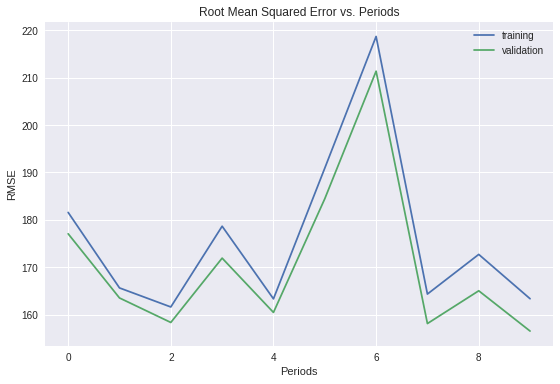

In [24]:
dnn_regressor, tptmp = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 168.11
  period 01 : 165.62
  period 02 : 156.59
  period 03 : 177.04
  period 04 : 163.27
  period 05 : 133.98
  period 06 : 141.20
  period 07 : 139.98
  period 08 : 134.26
  period 09 : 157.85
Model training finished.
Final RMSE (on training data):   157.85
Final RMSE (on validation data): 156.36


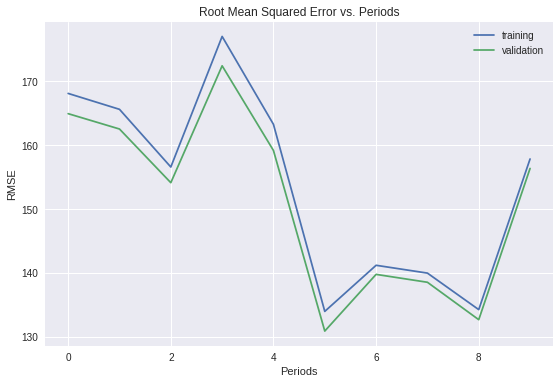

In [25]:
dnn_regressor, tptmp = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=100,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 225.18
  period 01 : 212.48
  period 02 : 200.10
  period 03 : 188.11
  period 04 : 176.57
  period 05 : 165.59
  period 06 : 155.28
  period 07 : 145.79
  period 08 : 137.28
  period 09 : 129.96
Model training finished.
Final RMSE (on training data):   129.96
Final RMSE (on validation data): 128.39


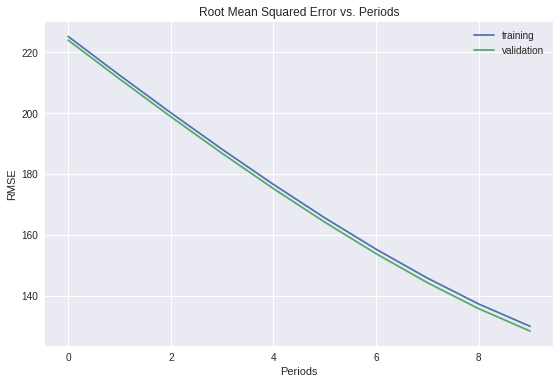

In [29]:
dnn_regressor, tptmp = train_nn_regression_model(
    learning_rate=0.06,
    steps=500,
    batch_size=100,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 237.16
  period 01 : 236.10
  period 02 : 235.02
  period 03 : 233.94
  period 04 : 232.85
  period 05 : 231.77
  period 06 : 230.69
  period 07 : 229.61
  period 08 : 228.54
  period 09 : 227.47
Model training finished.
Final RMSE (on training data):   227.47
Final RMSE (on validation data): 226.26


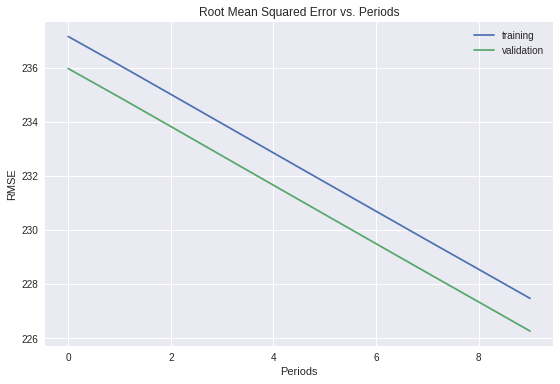

In [30]:
dnn_regressor, tptmp = train_nn_regression_model(
    learning_rate=0.005,
    steps=500,
    batch_size=100,
    hidden_units=[9, 6, 3],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 162.50
  period 01 : 143.35
  period 02 : 133.01
  period 03 : 128.11
  period 04 : 124.31
  period 05 : 123.73
  period 06 : 117.75
  period 07 : 117.66
  period 08 : 120.25
  period 09 : 118.81
Model training finished.
Final RMSE (on training data):   118.81
Final RMSE (on validation data): 116.92


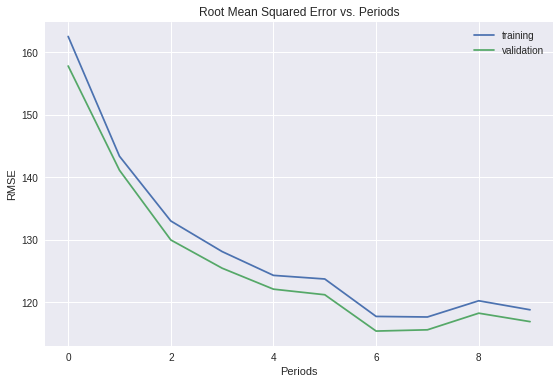

In [28]:
dnn_regressor, tptmp = train_nn_regression_model(
    learning_rate=0.005,
    steps=2000,
    batch_size=300,
    hidden_units=[9, 7, 5, 3],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 162.89
  period 01 : 156.02
  period 02 : 148.71
  period 03 : 143.45
  period 04 : 131.97
  period 05 : 126.42
  period 06 : 116.43
  period 07 : 117.41
  period 08 : 112.64
  period 09 : 106.70
Model training finished.
Final RMSE (on training data):   106.70
Final RMSE (on validation data): 105.62


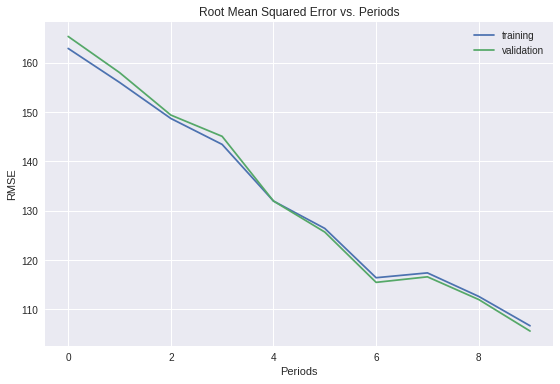

In [26]:
dnn_regressor, tptmp = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[12, 10, 6],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [61]:
training_examples.shape

(12000, 9)

In [45]:
type(tptmp)

generator

In [0]:
for item in tptmp:
  print(item['predictions'][0])

### Solution

Click below to see a possible solution

**NOTE:** This selection of parameters is somewhat arbitrary. Here we've tried combinations that are increasingly complex, combined with training for longer, until the error falls below our objective. This may not be the best combination; others may attain an even lower RMSE. If your aim is to find the model that can attain the best error, then you'll want to use a more rigorous process, like a parameter search.

Training model...
RMSE (on training data):
  period 00 : 160.97
  period 01 : 133.45
  period 02 : 119.23
  period 03 : 122.78
  period 04 : 109.66
  period 05 : 105.28
  period 06 : 115.60
  period 07 : 110.77
  period 08 : 101.75
  period 09 : 105.88
Model training finished.
Final RMSE (on training data):   105.88
Final RMSE (on validation data): 103.41


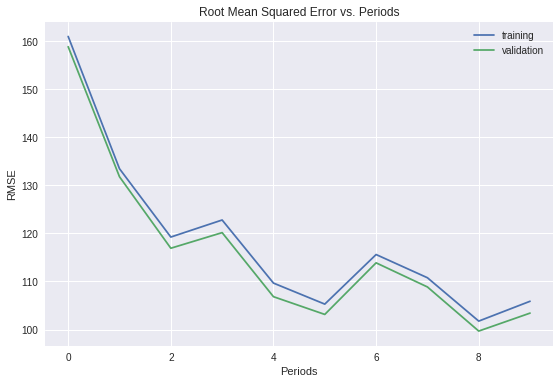

In [61]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.003,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 2: Evaluate on Test Data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located [here](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# YOUR CODE HERE

In [28]:
california_housing_test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.0,37.4,27.0,3885.0,661.0,1537.0,606.0,6.6,344700.0
1,-118.3,34.3,43.0,1510.0,310.0,809.0,277.0,3.6,176500.0
2,-117.8,33.8,27.0,3589.0,507.0,1484.0,495.0,5.8,270500.0
3,-118.4,33.8,28.0,67.0,15.0,49.0,11.0,6.1,330000.0
4,-119.7,36.3,19.0,1241.0,244.0,850.0,237.0,2.9,81700.0


In [0]:
california_housing_test_data = california_housing_test_data.reindex(
    np.random.permutation(california_housing_test_data.index))

In [30]:
california_housing_test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
141,-122.2,37.8,36.0,1678.0,606.0,1645.0,543.0,2.2,116700.0
2610,-117.5,33.9,17.0,5364.0,1020.0,3754.0,936.0,3.3,139100.0
1070,-122.2,37.5,38.0,1300.0,269.0,608.0,292.0,4.6,286900.0
2988,-122.0,37.0,43.0,2162.0,509.0,1208.0,464.0,2.5,260900.0
2414,-120.8,37.1,16.0,3736.0,761.0,1942.0,730.0,2.6,120200.0


In [0]:
test_data_features = preprocess_features(california_housing_test_data)
test_data_targets = preprocess_targets(california_housing_test_data)

In [33]:
test_data_features.tail()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
2682,37.8,-122.4,52.0,2164.0,533.0,1122.0,469.0,3.3,1.9
2978,38.6,-121.3,17.0,2761.0,501.0,1128.0,482.0,3.8,2.4
2639,37.2,-121.8,21.0,3250.0,610.0,1978.0,568.0,4.5,1.6
200,40.8,-123.3,25.0,767.0,206.0,301.0,121.0,1.6,2.5
2347,33.7,-118.0,18.0,3698.0,574.0,2046.0,614.0,6.3,1.8


In [34]:
test_data_targets.tail()

,median_house_value
2682,306.0
2978,139.7
2639,234.4
200,79.2
2347,269.8


Training model...
RMSE (on training data):
  period 00 : 159.09
  period 01 : 151.74
  period 02 : 145.36
  period 03 : 135.57
  period 04 : 127.27
  period 05 : 121.88
  period 06 : 113.28
  period 07 : 116.39
  period 08 : 108.78
  period 09 : 115.06
Model training finished.
Final RMSE (on training data):   115.06
Final RMSE (on validation data): 112.04


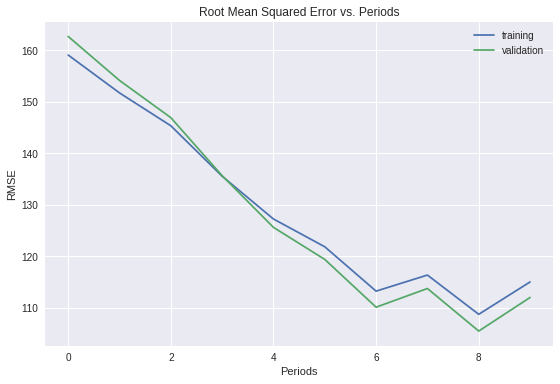

In [35]:
dnn_regressor, tptmp = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[12, 10, 6],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [0]:
test_data_predicts = dnn_regressor.predict(test_data_features)

In [39]:
type(test_data_predicts)

generator

In [0]:
batch_size = 100

In [0]:
test_data_input_fn = lambda: my_input_fn(test_data_features, 
                                          test_data_targets["median_house_value"], 
                                          batch_size=batch_size)

In [0]:
test_data_predicts = dnn_regressor.predict(test_data_input_fn)
test_data_predicts = np.array([item['predictions'][0] for item in test_data_predicts])

In [3]:
 test_data_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test_data_predicts, test_data_targets))

NameError: ignored

### Solution

Click below to see a possible solution.

Similar to what the code at the top does, we just need to load the appropriate data file, preprocess it and call predict and mean_squared_error.

Note that we don't have to randomize the test data, since we will use all records.

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)